### ✅ Step 0: Environment Setup

In [13]:
!pip install owlready2 pandas numpy matplotlib tqdm

### ✅ Step 1: Ontology Definition

In [14]:
from owlready2 import *
from uuid import uuid4

onto = get_ontology("http://example.org/rail.owl")
with onto:
    # --- core domain ----------------------------------------------------
    class Person(Thing): pass
    class Student(Person): pass                # ← extension 1
    class Employer(Thing): pass
    class Ticket(Thing): pass
    class FlexibleSeasonTicket(Ticket): pass
    class Warning(Thing): pass                 # low-contribution flag

    # --- object props ---------------------------------------------------
    class works_for(Person >> Employer): pass
    class has_ticket(Person >> Ticket): pass

    # --- data props -----------------------------------------------------
    class price(Ticket >> float, DataProperty): pass
    class peak_start(Ticket >> bool, DataProperty): pass   # extension 2
    class multi_modal(Ticket >> bool, DataProperty): pass  # extension 3
    class employer_contribution(Employer >> float, DataProperty): pass


### ✅ Step 2: Rules Engine (aggregates + NAF + existentials)


In [15]:
import random, datetime as dt

class RailRules:
    def __init__(self, onto):
        self.onto = onto

    # 3.2 — Negation-as-Failure + aggregate
    def min_employer_contrib(self, ratio=0.30):
        for emp in self.onto.Employer.instances():
            tickets = [t for p in self.onto.Person.instances()
                         if emp in p.works_for
                         for t in p.has_ticket]
            total = sum(t.price.first() for t in tickets)
            paid  = emp.employer_contribution.first()
            if total > 0 and paid < ratio * total:
                # create one warning per employer (existential)
                name = f"LowContribution_{uuid4().hex[:6]}"
                w = self.onto.Warning(name)
                w.comment = [f"{emp.name}: {paid/total:.0%} (<{ratio:.0%})"]

    # extra business rules ----------------------------------------------
    def student_discount(self):
        for p in self.onto.Student.instances():
            for t in p.has_ticket:
                t.price = [round(0.8 * t.price.first(), 2)]  # 20 % off

    def peak_surcharge(self):
        for t in self.onto.Ticket.instances():
            if t.peak_start.first():          # boolean flag set in data gen
                t.price = [round(1.15 * t.price.first(), 2)]

    def multimodal_supplement(self):
        for t in self.onto.Ticket.instances():
            if t.multi_modal.first():
                t.price = [round(t.price.first() + 25, 2)]

    def run(self):
        self.student_discount()
        self.peak_surcharge()
        self.multimodal_supplement()
        self.min_employer_contrib()

engine = RailRules(onto)


### ✅ Step 3: Synthetic Data Generator


In [16]:
import numpy as np
from tqdm.auto import trange

N_EMP          = 10
N_PERSON_EMP   = 50
PEAK_RATE      = 0.35     # 35 % of tickets start in peak
MULTI_RATE     = 0.25     # 25 % are multimodal
STUDENT_RATE   = 0.15     # 15 % of persons are students

rng = np.random.default_rng(42)
for e in range(N_EMP):
    emp  = onto.Employer(f"Emp_{e:02d}")
    total_price = 0
    for p in range(N_PERSON_EMP):
        is_student = rng.random() < STUDENT_RATE
        person_cls = onto.Student if is_student else onto.Person
        person = person_cls(f"P_{e:02d}_{p:03d}")
        person.works_for = [emp]

        base_price = rng.uniform(60, 250)
        t = onto.FlexibleSeasonTicket(f"T_{uuid4().hex[:8]}")
        t.price      = [round(base_price,2)]
        t.peak_start = [rng.random() < PEAK_RATE]
        t.multi_modal= [rng.random() < MULTI_RATE]
        person.has_ticket = [t]

        total_price += base_price
    emp.employer_contribution = [round(rng.uniform(.25, .55) * total_price, 2)]

print("👍 Data populated")


👍 Data populated


### ✅ Step 4: Fire all rules once

In [17]:
engine.run()
print("Warnings flagged:", len(list(onto.Warning.instances())))

Warnings flagged: 624


### ✅ Step 5: Collect quote results


In [18]:
import pandas as pd

rows = []
for p in onto.Person.instances():
    t   = p.has_ticket.first()
    emp = p.works_for.first()
    rows.append({
        "person"     : p.name,
        "student"    : isinstance(p, onto.Student),
        "ticket"     : t.name,
        "peak"       : t.peak_start.first(),
        "multi_mod"  : t.multi_modal.first(),
        "price"      : t.price.first(),
        "employer"   : emp.name,
        "emp_contrib": emp.employer_contribution.first()
    })
df = pd.DataFrame(rows)
df["employee_pay"] = df.price - df.emp_contrib / N_PERSON_EMP
df.to_csv("quote_results.csv", index=False)
df.head()

,person,student,ticket,peak,multi_mod,price,employer,emp_contrib,employee_pay
0,P_00_000,False,T_68531c13,False,False,143.39,Emp_00,3976.96,63.8508
1,P_00_001,True,T_580dcc84,False,False,196.30,Emp_00,3976.96,116.7608
2,P_00_002,True,T_81296475,False,False,116.46,Emp_00,3976.96,36.9208
3,P_00_003,False,T_dba299fe,False,True,241.32,Emp_00,3976.96,161.7808
4,P_00_004,False,T_177cd843,False,False,72.13,Emp_00,3976.96,-7.4092


### ✅ Step 6: Business-level KPIs plot


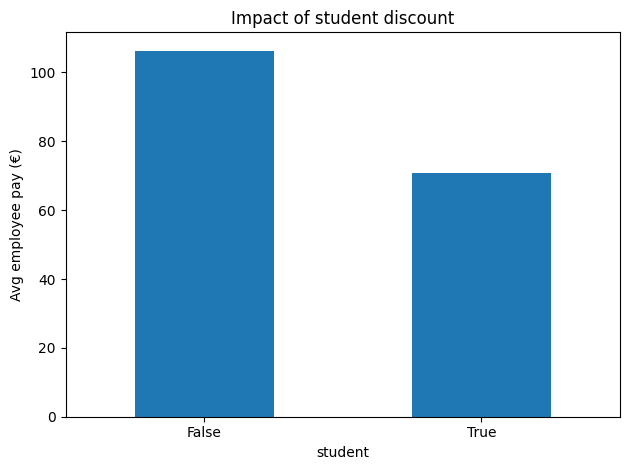

In [19]:
import matplotlib.pyplot as plt

plt.figure()
df.groupby("student").employee_pay.mean().plot(kind="bar")
plt.ylabel("Avg employee pay (€)")
plt.title("Impact of student discount")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("kpi_student.png"); plt.show()


### ✅ Step 7: “Latency-style” micro-benchmark


in-mem queries:   0%|          | 0/5000 [00:00<?, ?it/s]

mean 2.2 µs   p95 2.6 µs   qps 458961.5


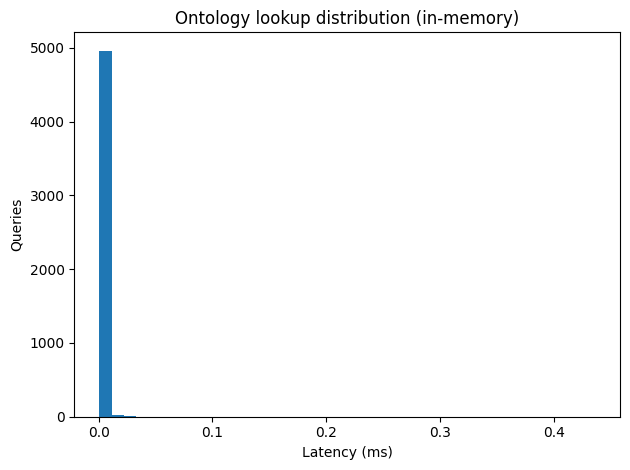

In [20]:
import time, random

SAMPLES = 5_000
latencies = []
persons = list(onto.Person.instances())
for _ in trange(SAMPLES, desc="in-mem queries"):
    p = random.choice(persons)
    t0 = time.perf_counter()
    _ = p.has_ticket.first().price.first()      # trivial read
    latencies.append((time.perf_counter() - t0)*1e6)  # μs

lat = np.array(latencies)
print(f"mean {lat.mean():.1f} µs   p95 {np.percentile(lat,95):.1f} µs   qps {1e6/lat.mean():.1f}")

plt.figure()
plt.hist(lat/1000, bins=40)
plt.xlabel("Latency (ms)")
plt.ylabel("Queries")
plt.title("Ontology lookup distribution (in-memory)")
plt.tight_layout()
plt.savefig("latency_hist.png"); plt.show()


In [21]:
## Save ontology
# onto.save(file="rail_core.owl", format="rdfxml")